In [1]:
torch.setdefaulttensortype('torch.FloatTensor')

## Generate reference results using the OLD `IntegralSmartNorm`

In [2]:
require 'image'

nInputPlane = 3
nWindows = 4
h = 200
w = 200

referencePath = 'Checker/reference.t7'
if lfs.attributes(referencePath) then
    reference = torch.load(referencePath)
else
    reference = {}
    reference.image = image.scale(image.lena(), h, w)
    
    reference.xMin = torch.Tensor{-200, 35.5,  99, 0.0}
    reference.xMax = torch.Tensor{-195, 35.5, 100, 1.1}
    reference.yMin = torch.Tensor{  95, -1.0,  99,  -10}
    reference.yMax = torch.Tensor{ 100, -1.0, 100,   0}
    
    IntegralSmartNorm = nil
    debug.getregistry()['IntegralSmartNorm'] = nil 
    package.loaded['IntegralSmartNorm'] = nil
    require 'IntegralSmartNorm'
    
    int = IntegralSmartNorm(nWindows, h, w)
    int.exact = true
    int.smart = true
    for _, param in ipairs{'xMin', 'xMax', 'yMin', 'yMax'} do
        int[param]:copy(reference[param])
    end
    
    int:forward(reference.image)
    reference.outputNonNorm = int.outputNonNorm:clone()
    reference.outputOnes = torch.repeatTensor(int.outputOnes, nInputPlane, 1, 1)
    
    torch.manualSeed(666)
    reference.gradOutput = torch.rand(int.output:size())
    int:backward(reference.image, reference.gradOutput)
    for _, param in ipairs{'gradInput', 'gradXMin', 'gradXMax', 'gradYMin', 'gradYMax'} do
        reference[param] = int[param]
    end
    
--     torch.save(referencePath, reference)
end

### Check new `IntegralSmartNorm`'s output against the reference

outputOnes diff:	7.3589125879228	


outputNonNorm diff:	0	


gradInput diff:	10149.802734375	
1	0.065527349710464	10077.318359375	


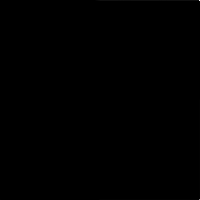

2	0.12714844942093	10103.162109375	


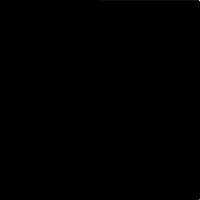

3	0.27098697423935	10058.65234375	


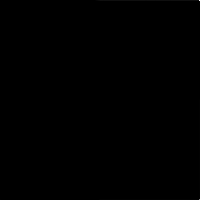

./IntegralSmartNorm.lua:780: bad argument #3 to 'backwardNoNormFrac' (cannot convert 'nil' to 'float')
stack traceback:
	[C]: in function 'backwardNoNormFrac'
	./IntegralSmartNorm.lua:780: in function 'accGradParameters'
	[string "IntegralSmartNorm = nil..."]:26: in main chunk
	[C]: in function 'xpcall'
	...ubb/Programs/Torch/install/share/lua/5.1/itorch/main.lua:210: in function <...ubb/Programs/Torch/install/share/lua/5.1/itorch/main.lua:174>
	...ubb/Programs/Torch/install/share/lua/5.1/lzmq/poller.lua:75: in function 'poll'
	.../Programs/Torch/install/share/lua/5.1/lzmq/impl/loop.lua:307: in function 'poll'
	.../Programs/Torch/install/share/lua/5.1/lzmq/impl/loop.lua:325: in function 'sleep_ex'
	.../Programs/Torch/install/share/lua/5.1/lzmq/impl/loop.lua:370: in function 'start'
	...ubb/Programs/Torch/install/share/lua/5.1/itorch/main.lua:389: in main chunk
	[C]: in function 'require'
	(command line):1: in main chunk
	[C]: at 0x00405e40: 

In [5]:
IntegralSmartNorm = nil
debug.getregistry()['IntegralSmartNorm'] = nil 
package.loaded['IntegralSmartNorm'] = nil
require 'IntegralSmartNorm'

int = IntegralSmartNorm(nInputPlane, nWindows, h, w)
int.exact = true
int.smart = true
int.replicate = true
for _, param in ipairs{'xMin', 'xMax', 'yMin', 'yMax'} do
    int[param]:copy(torch.repeatTensor(reference[param], nInputPlane))
end

int:forward(reference.image)
print('outputOnes diff:', (reference.outputOnes - int.outputOnes):abs():mean())
print('outputNonNorm diff:', (reference.outputNonNorm - int.outputNonNorm):abs():max())

int:updateGradInput(reference.image, reference.gradOutput)
print('gradInput diff:', (reference.gradInput - int.gradInput):abs():max())
for k = 1,3 do
    local t =int.gradInput[k]
    print(k, t:min(), t:max())
    itorch.image(t)
end

int:accGradParameters(reference.image, reference.gradOutput)
for _, param in ipairs{'gradInput', 'gradXMin', 'gradXMax', 'gradYMin', 'gradYMax'} do
--     print(param .. ' diff:', 
--         (reference[param] - int[param]:view(nInputPlane, nWindows):sum(1)):abs():max())
end

In [6]:
IntegralSmartNorm = nil
debug.getregistry()['IntegralSmartNorm'] = nil 
package.loaded['IntegralSmartNorm'] = nil
require 'IntegralSmartNorm'

torch.manualSeed(666)
local h,w = 4,4
img = torch.ones(1, h, w)

int = IntegralSmartNorm(1, 2, h, w)
pX, pY = 2,2

int.exact = true
int.smart = false
crit = nn.MSECriterion()
target = torch.ones(int.nWindows, h, w)

--     reference.xMin = torch.Tensor{-200, 35.5,  99, 0.0}
--     reference.xMax = torch.Tensor{-195, 35.5, 100, 1.1}
--     reference.yMin = torch.Tensor{  95, -1.0,  99,  -10}
--     reference.yMax = torch.Tensor{ 100, -1.0, 100,   0}
int.xMin[1][1] = -1
int.xMax[1][1] = 1
int.yMin[1][1] = 1
int.yMax[1][1] = 3

int.xMin[1][2] = 1.5
int.xMax[1][2] = 1.5
int.yMin[1][2] = -1
int.yMax[1][2] = -1

img[{1,pX,pY}] = 5
int:forward(img)

print(int.xMin[1][1])
print(int.xMax[1][1])
print(int.yMin[1][1])
print(int.yMax[1][1])

print('input')
print(img)
print('output')
print(int.output)
print('target')
print(target)
loss = crit:forward(int.output, target)
print('loss')
print(loss)
gradOutput = crit:updateGradInput(int.output, target)
print('gradOutput')
print(gradOutput)
int:updateGradInput(img, gradOutput)
print('gradInput')
print(int.gradInput)
print(int.gradInput:min(), int.gradInput:max())

params = {}
loss = {}
deriv = {}
derivM = {}

local k = 1
local step = 0.05
local innerStep = 0.005

-- do return end
for param = -10,16,step do
    params[k] = param
    img[{1,pX,pY}] = param
    pred = int:forward(img)
    loss[k] = crit:forward(pred, target)
    
    int:updateGradInput(img, crit:updateGradInput(pred, target))
    derivM[k] = int.gradInput[{1,pX,pY}]
    
    img[{1,pX,pY}] = param + innerStep
    valFront = crit:forward(int:forward(img), target)
    img[{1,pX,pY}] = param - innerStep
    valBack = crit:forward(int:forward(img), target)
    
    deriv[k] = (valFront - valBack) / (2 * innerStep)
    
    k = k + 1
end

-- loss[#loss] = nil
-- params[#params] = nil
-- derivM[#derivM] = nil

-1	
1	
1	
3	
input	


(1,.,.) = 
  1  1  1  1
  1  5  1  1
  1  1  1  1
  1  1  1  1
[torch.FloatTensor of size 1x4x4]

output	
(1,.,.) = 
  10   4   2   2
  13   6   3   3
  13   6   3   3
   6   4   2   2

(2,.,.) = 
   1   1   3   1
   1   1   1   1
   1   1   1   1
   1   1   1   1
[torch.FloatTensor of size 2x4x4]

target	
(1,.,.) = 
  1  1  1  1
  1  1  1  1
  1  1  1  1
  1  1  1  1

(2,.,.) = 
  1  1  1  1
  1  1  1  1
  1  1  1  1
  1  1  1  1
[torch.FloatTensor of size 2x4x4]



loss	
15.1875	
gradOutput	


(1,.,.) = 
  0.5625  0.1875  0.0625  0.0625
  0.7500  0.3125  0.1250  0.1250
  0.7500  0.3125  0.1250  0.1250
  0.3125  0.1875  0.0625  0.0625

(2,.,.) = 
  0.0000  0.0000  0.1250  0.0000
  0.0000  0.0000  0.0000  0.0000
  0.0000  0.0000  0.0000  0.0000
  0.0000  0.0000  0.0000  0.0000
[torch.FloatTensor of size 2x4x4]

gradInput	


(1,.,.) = 
  0.0000  1.3125  1.8125  2.1875
  0.0000  2.1250  2.8750  3.5000
  0.0000  1.8750  2.6250  3.2500
  0.0000  1.0625  1.5625  1.9375
[torch.FloatTensor of size 1x4x4]

0	3.5	


In [7]:
require 'gnuplot'

gnuplot.plot(
    {'Loss', torch.Tensor(params), torch.Tensor(loss), '-'},
    {'Diff', torch.Tensor(params), torch.Tensor(deriv), '-'},
    {'Manual', torch.Tensor(params), torch.Tensor(derivM), '-'}
)
gnuplot.grid(true)

In [5]:
input = torch.Tensor{{1,2,3},{4,5,6},{7,8,9}}
int = IntegralSmartNorm(1, 1, 3, 3)

int.smart = false
int.exact = true
int.replicate = false

int.xMin[1][1] = 1.4
int.xMax[1][1] = 1.55
int.yMin[1][1] = 0
int.yMax[1][1] = 0

gradOutput = input:clone()
print(input)
print(int:forward(input))
print(gradOutput)
int:updateGradInput(input, gradOutput)
print(int.xMinInt[1], int.xMinFrac[1])
print(int.xMaxInt[1], int.xMaxFrac[1])
print(int.yMinInt[1], int.yMinFrac[1])
print(int.yMaxInt[1], int.yMaxFrac[1])
print(int.gradInput)

 1  2  3
 4  5  6
 7  8  9
[torch.FloatTensor of size 3x3]



(1,.,.) = 
  6.2500  7.4000  8.5500
  4.2000  4.8000  5.4000
  0.0000  0.0000  0.0000
[torch.FloatTensor of size 1x3x3]

 1  2  3
 4  5  6
 7  8  9
[torch.FloatTensor of size 3x3]



-1	0.54999995231628	
-1	0.60000002384186	
0	0	
1	0	
(1,.,.) = 
   0.0000   0.0000   0.0000
   0.6000   1.2000   1.8000
  11.5500  14.1000  16.6500
[torch.FloatTensor of size 1x3x3]

